# Custom Object Detectors 

<a href="https://colab.research.google.com/drive/1pfMiefP8t2nhb92IHKgYmjfdorHSt2VD?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By [Ibrahim Sobh](https://www.linkedin.com/in/ibrahim-sobh-phd-8681757/)

In this notebook, we will download 10 well known pre-trained object detectors, select one of them and fine tune it on a custom dataset kitti-tiny.

1. YOLOF: You Only Look One-level Feature (2021)
2. YOLOX: Exceeding YOLO Series in 2021 (2021)
4. Deformable DETR: Deformable Transformers for End-to-End Object Detection (2021)
4. SparseR-CNN: End-to-End Object Detection with Learnable Proposals (2020)
5. VarifocalNet: An IoU-aware Dense Object Detector (2020)
6. PAA: Probabilistic Anchor Assignment with IoU Prediction for Object Detection (2020)
7. DETR: End-to-End Object Detection with Transformers (2020)
8. SABL: Side-Aware Boundary Localization for More Precise Object Detection (2020)
9. ATSS: Bridging the Gap Between Anchor-based and Anchor-free Detection via Adaptive Training Sample Selection (2019)
10. Double Heads: Rethinking Classification and Localization for Object Detection (2019)





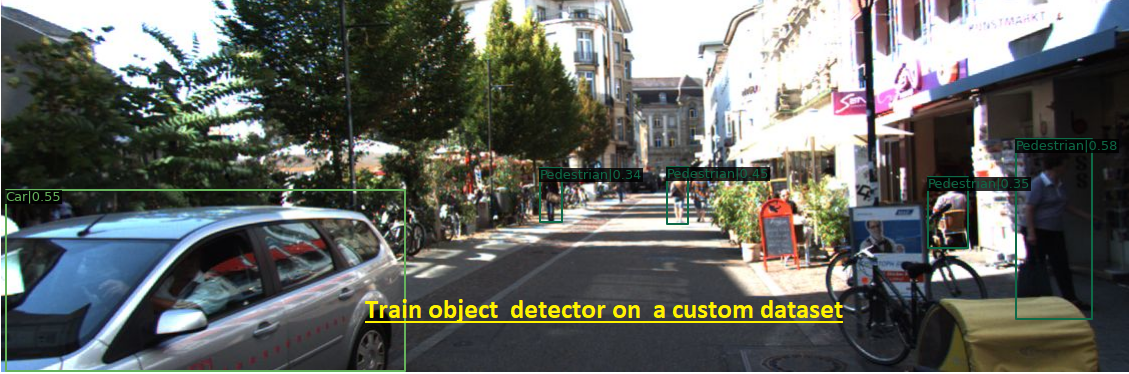

## Setup

In [1]:
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

Cloning into 'mmdetection'...
remote: Enumerating objects: 23137, done.
remote: Total 23137 (delta 0), reused 0 (delta 0), pack-reused 23137
Receiving objects: 100% (23137/23137), 25.87 MiB | 18.40 MiB/s, done.
Resolving deltas: 100% (16199/16199), done.
/content/mmdetection


In [2]:
!pip install openmim

  Created wheel for openmim: filename=openmim-0.1.5-py2.py3-none-any.whl size=42503 sha256=6f3f8c0889aea6a6180ede7377a02726632434db382bf0e9c23cdb1af3d4306e
  Stored in directory: /root/.cache/pip/wheels/16/8b/e1/bdebbbc687aa50224a5ce46fe97a040a0c59f92b34bfc750b6
Successfully built openmim


In [3]:
!mim install mmdet

installing mmdet from https://github.com/open-mmlab/mmdetection.git.
Cloning into '/tmp/tmposkh42hy/mmdetection'...
remote: Enumerating objects: 23137, done.
remote: Total 23137 (delta 0), reused 0 (delta 0), pack-reused 23137
Receiving objects: 100% (23137/23137), 25.87 MiB | 26.05 MiB/s, done.
Resolving deltas: 100% (16188/16188), done.
Note: checking out '98949809b7179fab9391663ee5a4ab5978425f90'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

installing dependency: mmcv-full
installing mmcv-full from wheel.
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
     |████████████████████████████████

In [4]:
import numpy as np
import os
import pandas as pd
import torch, torchvision
import mmcv
import mmdet
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
from mmdet.datasets import build_dataset
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset
from mmcv import Config
from mmdet.apis import inference_detector, init_detector, set_random_seed, show_result_pyplot
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
import os
import os.path as osp
import matplotlib.pyplot as plt

In [5]:
# Check Pytorch installation
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
print(mmdet.__version__)

# Check mmcv installation
print(get_compiling_cuda_version())
print(get_compiler_version())

1.10.0+cu111 True
2.21.0
11.1
GCC 7.3


## Download Checkpoints

In [6]:
!mkdir checkpoints

# YOLOF: https://github.com/open-mmlab/mmdetection/tree/master/configs/yolof
!wget -c https://download.openmmlab.com/mmdetection/v2.0/yolof/yolof_r50_c5_8x8_1x_coco/yolof_r50_c5_8x8_1x_coco_20210425_024427-8e864411.pth \
      -O checkpoints/yolof_r50_c5_8x8_1x_coco_20210425_024427-8e864411.pth

# YOLOX: https://github.com/open-mmlab/mmdetection/tree/master/configs/yolox
!wget -c https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_tiny_8x8_300e_coco/yolox_tiny_8x8_300e_coco_20211124_171234-b4047906.pth \
      -O checkpoints/yolox_tiny_8x8_300e_coco_20211124_171234-b4047906.pth


# Sparse R-CNN: https://github.com/open-mmlab/mmdetection/tree/master/configs/sparse_rcnn
!wget -c https://download.openmmlab.com/mmdetection/v2.0/sparse_rcnn/sparse_rcnn_r50_fpn_1x_coco/sparse_rcnn_r50_fpn_1x_coco_20201222_214453-dc79b137.pth \
      -O checkpoints/sparse_rcnn_r50_fpn_1x_coco_20201222_214453-dc79b137.pth

# VarifocalNet: https://github.com/open-mmlab/mmdetection/tree/master/configs/vfnet
!wget -c https://download.openmmlab.com/mmdetection/v2.0/vfnet/vfnet_r50_fpn_1x_coco/vfnet_r50_fpn_1x_coco_20201027-38db6f58.pth \
      -O checkpoints/vfnet_r50_fpn_1x_coco_20201027-38db6f58.pth

# PAA: https://github.com/open-mmlab/mmdetection/tree/master/configs/paa
!wget -c https://download.openmmlab.com/mmdetection/v2.0/paa/paa_r50_fpn_1x_coco/paa_r50_fpn_1x_coco_20200821-936edec3.pth \
      -O checkpoints/paa_r50_fpn_1x_coco_20200821-936edec3.pth

# DETR: https://github.com/open-mmlab/mmdetection/tree/master/configs/detr
!wget -c https://download.openmmlab.com/mmdetection/v2.0/detr/detr_r50_8x2_150e_coco/detr_r50_8x2_150e_coco_20201130_194835-2c4b8974.pth \
      -O checkpoints/detr_r50_8x2_150e_coco_20201130_194835-2c4b8974.pth

# Deformable DETR: https://github.com/open-mmlab/mmdetection/tree/master/configs/deformable_detr
!wget -c https://download.openmmlab.com/mmdetection/v2.0/deformable_detr/deformable_detr_r50_16x2_50e_coco/deformable_detr_r50_16x2_50e_coco_20210419_220030-a12b9512.pth \
      -O checkpoints/deformable_detr_r50_16x2_50e_coco_20210419_220030-a12b9512.pth

# SABL: https://github.com/open-mmlab/mmdetection/tree/master/configs/sabl
!wget -c https://download.openmmlab.com/mmdetection/v2.0/sabl/sabl_faster_rcnn_r50_fpn_1x_coco/sabl_faster_rcnn_r50_fpn_1x_coco-e867595b.pth \
      -O checkpoints/sabl_faster_rcnn_r50_fpn_1x_coco-e867595b.pth

# ATSS: https://github.com/open-mmlab/mmdetection/tree/master/configs/atss
!wget -c https://download.openmmlab.com/mmdetection/v2.0/atss/atss_r50_fpn_1x_coco/atss_r50_fpn_1x_coco_20200209-985f7bd0.pth \
      -O checkpoints/atss_r50_fpn_1x_coco_20200209-985f7bd0.pth

# Double Heads: https://github.com/open-mmlab/mmdetection/tree/master/configs/double_heads
!wget -c https://download.openmmlab.com/mmdetection/v2.0/double_heads/dh_faster_rcnn_r50_fpn_1x_coco/dh_faster_rcnn_r50_fpn_1x_coco_20200130-586b67df.pth \
      -O checkpoints/dh_faster_rcnn_r50_fpn_1x_coco_20200130-586b67df.pth


--2022-02-19 08:51:34--  https://download.openmmlab.com/mmdetection/v2.0/yolof/yolof_r50_c5_8x8_1x_coco/yolof_r50_c5_8x8_1x_coco_20210425_024427-8e864411.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 176992053 (169M) [application/octet-stream]
Saving to: ‘checkpoints/yolof_r50_c5_8x8_1x_coco_20210425_024427-8e864411.pth’

checkpoints/yolof_r 100%[===================>] 168.79M  7.82MB/s    in 23s     

2022-02-19 08:51:59 (7.18 MB/s) - ‘checkpoints/yolof_r50_c5_8x8_1x_coco_20210425_024427-8e864411.pth’ saved [176992053/176992053]

--2022-02-19 08:51:59--  https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_tiny_8x8_300e_coco/yolox_tiny_8x8_300e_coco_20211124_171234-b4047906.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.open

In [7]:
# model and config lists 
config_list = ['./configs/yolof/yolof_r50_c5_8x8_1x_coco.py',
               './configs/yolox/yolox_tiny_8x8_300e_coco.py',
               './configs/sparse_rcnn/sparse_rcnn_r50_fpn_1x_coco.py',
               './configs/vfnet/vfnet_r50_fpn_1x_coco.py',
               './configs/paa/paa_r50_fpn_1x_coco.py',
               './configs/detr/detr_r50_8x2_150e_coco.py',
               './configs/deformable_detr/deformable_detr_r50_16x2_50e_coco.py',
               './configs/sabl/sabl_faster_rcnn_r50_fpn_1x_coco.py',
               './configs/atss/atss_r50_fpn_1x_coco.py',
               './configs/double_heads/dh_faster_rcnn_r50_fpn_1x_coco.py']


checkpoint_list = ['./checkpoints/yolof_r50_c5_8x8_1x_coco_20210425_024427-8e864411.pth',
                   './checkpoints/yolox_tiny_8x8_300e_coco_20211124_171234-b4047906.pth',
                   './checkpoints/sparse_rcnn_r50_fpn_1x_coco_20201222_214453-dc79b137.pth',
                   './checkpoints/vfnet_r50_fpn_1x_coco_20201027-38db6f58.pth',
                   './checkpoints/paa_r50_fpn_1x_coco_20200821-936edec3.pth',
                   './checkpoints/detr_r50_8x2_150e_coco_20201130_194835-2c4b8974.pth',
                   './checkpoints/deformable_detr_r50_16x2_50e_coco_20210419_220030-a12b9512.pth',
                   './checkpoints/sabl_faster_rcnn_r50_fpn_1x_coco-e867595b.pth',
                   './checkpoints/atss_r50_fpn_1x_coco_20200209-985f7bd0.pth',
                   './checkpoints/dh_faster_rcnn_r50_fpn_1x_coco_20200130-586b67df.pth']

detectors_names = ['YOLOF: You Only Look One-level Feature (2021)',
                   'YOLOX: Exceeding YOLO Series in 2021 (2021)',
                   'SparseR-CNN: End-to-End Object Detection with Learnable Proposals (2020)',
                   'VarifocalNet: An IoU-aware Dense Object Detector (2020)',
                   'PAA: Probabilistic Anchor Assignment with IoU Prediction for Object Detection (2020)',
                   'DETR: End-to-End Object Detection with Transformers (2020)',
                   'Deformable DETR: Deformable Transformers for End-to-End Object Detection (2021)',
                   'SABL: Side-Aware Boundary Localization for More Precise Object Detection (2020)',
                   'ATSS: Bridging the Gap Between Anchor-based and Anchor-free Detection via Adaptive Training Sample Selection (2019)',
                   'Double Heads: Rethinking Classification and Localization for Object Detection (2019)']


## Train a new model with a custom dataset

### Download, decompress the kitti tiny data

In [9]:
!wget https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
!unzip kitti_tiny.zip > /dev/null

--2022-02-19 08:56:12--  https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6918271 (6.6M) [application/zip]
Saving to: ‘kitti_tiny.zip’

kitti_tiny.zip      100%[===================>]   6.60M  4.43MB/s    in 1.5s    

2022-02-19 08:56:15 (4.43 MB/s) - ‘kitti_tiny.zip’ saved [6918271/6918271]



load checkpoint from local path: ./checkpoints/yolof_r50_c5_8x8_1x_coco_20210425_024427-8e864411.pth


/content/mmdetection/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


<Figure size 1080x720 with 0 Axes>

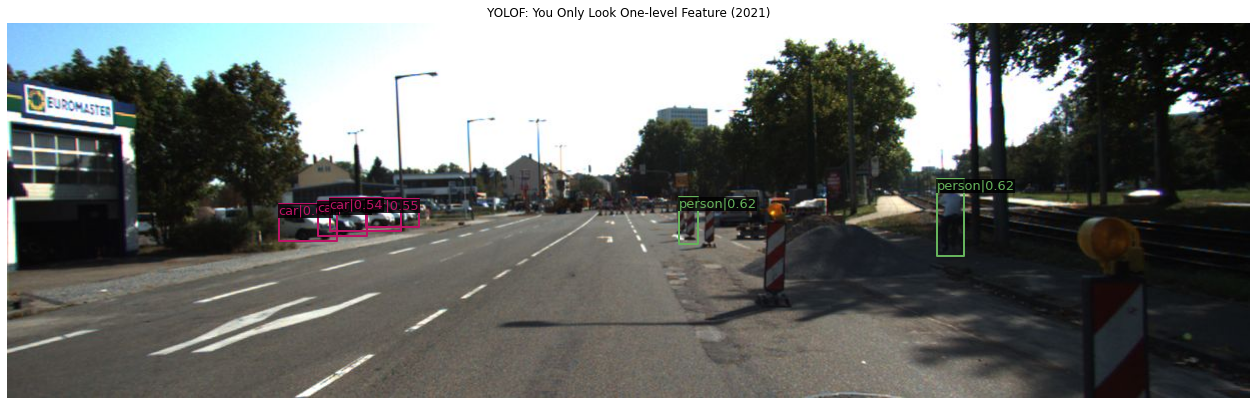

In [11]:
# Select a model and perform inference 
model_idx = 0
img = mmcv.imread('kitti_tiny/training/image_2/000051.jpeg')
model = init_detector(config_list[model_idx], checkpoint_list[model_idx], device='cuda:0')
result = inference_detector(model, img)
plt.figure(figsize=(15, 10))
show_result_pyplot(model, img, result, title=detectors_names[model_idx], score_thr=0.5)

### kitti dataset class

In [12]:
@DATASETS.register_module()
class KittiTinyDataset(CustomDataset):

    CLASSES = ('Car', 'Pedestrian', 'Cyclist')

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        # convert annotations to middle format
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpeg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpeg', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('image_2', 'label_2')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[4:8]] for x in content]
    
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            # filter 'DontCare'
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

### Modify the config

In [13]:
# This function is mainly generic, 
# however it may need updates based on the selected model  

def update_cfg(cfg_file, load_from=None, model_idx=0):
  #--------------------------------------
  # load config
  #--------------------------------------
  cfg = Config.fromfile(cfg_file)

  #--------------------------------------
  # Modify dataset type and path
  #--------------------------------------
  cfg.dataset_type = 'KittiTinyDataset'
  cfg.data_root = 'kitti_tiny/'
  cfg.data.test.type = 'KittiTinyDataset'
  cfg.data.test.data_root = 'kitti_tiny/'
  cfg.data.test.ann_file = 'train.txt'
  cfg.data.test.img_prefix = 'training/image_2'
  cfg.data.train.type = 'KittiTinyDataset'
  cfg.data.train.data_root = 'kitti_tiny/'
  cfg.data.train.ann_file = 'train.txt'
  cfg.data.train.img_prefix = 'training/image_2'
  cfg.data.val.type = 'KittiTinyDataset'
  cfg.data.val.data_root = 'kitti_tiny/'
  cfg.data.val.ann_file = 'val.txt'
  cfg.data.val.img_prefix = 'training/image_2'

  #--------------------------------------
  # Only 3 classes 
  # The follopwing line is specific per detector
  #--------------------------------------
  if model_idx==0:
    cfg.model.bbox_head.num_classes = 3
  else:
    print("Review the cfg file and see how to change it for 3 classes!")

  #--------------------------------------
  # Samples and workers per gpu = 1
  #--------------------------------------
  cfg.data.samples_per_gpu=1
  cfg.data.workers_per_gpu=1
  #--------------------------------------

  #--------------------------------------
  # load pretrained if needed
  #--------------------------------------
  #cfg.load_from = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'
  #cfg.load_from=None  # model is changed with a different backbone 
  cfg.load_from=load_from
  #--------------------------------------

  #--------------------------------------
  # Set up working dir to save files and logs.
  #--------------------------------------
  cfg.work_dir = './tutorial_exps'


  #--------------------------------------
  # learning rate (LR)
  #--------------------------------------
  cfg.optimizer.lr = 0.0001
  #--------------------------------------

  #--------------------------------------
  # Training 
  #--------------------------------------
  cfg.runner.max_epochs = 15
  cfg.lr_config.warmup = None
  cfg.log_config.interval = 10
  # Change the evaluation metric since we use customized dataset.
  cfg.evaluation.metric = 'mAP'
  # We can set the evaluation interval to reduce the evaluation times
  cfg.evaluation.interval = 15
  # We can set the checkpoint saving interval to reduce the storage cost
  cfg.checkpoint_config.interval = 15
  # Set seed thus the results are more reproducible
  cfg.seed = 0
  set_random_seed(0, deterministic=False)
  cfg.gpu_ids = range(1)

  return cfg

### Fine tune the model on the custom dataset

In [14]:
# select a model 
model_idx = 0

# update cfg file
cfg = update_cfg(config_list[model_idx], load_from=checkpoint_list[model_idx])

# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

# train (few epochs just for test)
train_detector(model, datasets, cfg, distributed=False, validate=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int`

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 6.4 task/s, elapsed: 4s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-02-19 09:05:08,111 - mmdet - INFO - 
+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap    |
+------------+-----+------+--------+-------+
| Car        | 62  | 1000 | 0.903  | 0.780 |
| Pedestrian | 13  | 613  | 0.923  | 0.790 |
| Cyclist    | 7   | 425  | 0.714  | 0.044 |
+------------+-----+------+--------+-------+
| mAP        |     |      |        | 0.538 |
+------------+-----+------+--------+-------+
2022-02-19 09:05:08,115 - mmdet - INFO - Epoch(val) [15][25]	AP50: 0.5380, mAP: 0.5381


/content/mmdetection/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


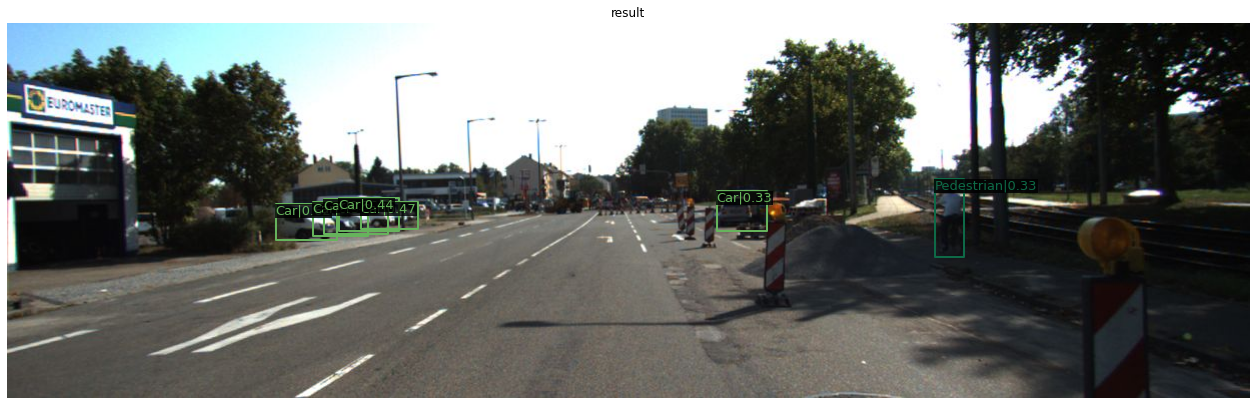

In [15]:
img = mmcv.imread('kitti_tiny/training/image_2/000051.jpeg')
model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)

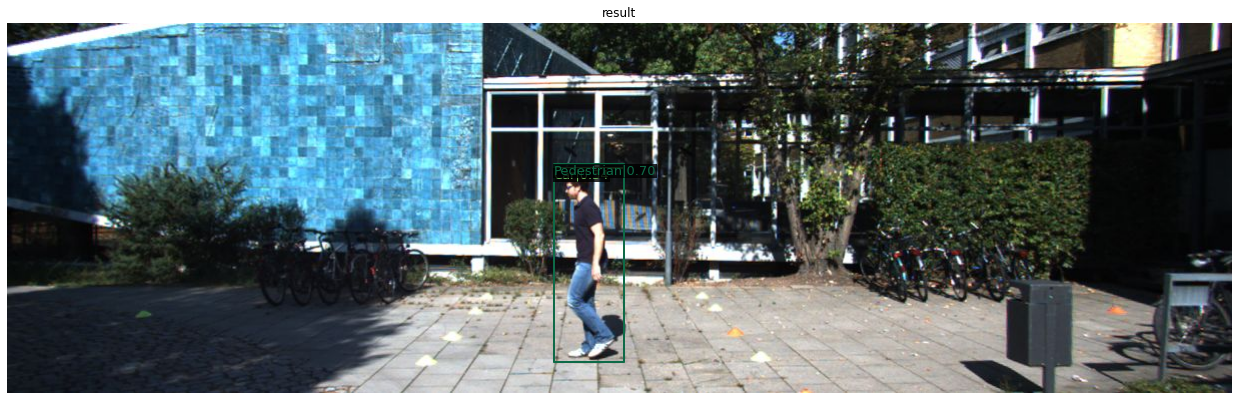

In [16]:
img = mmcv.imread('kitti_tiny/training/image_2/000070.jpeg')
model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)

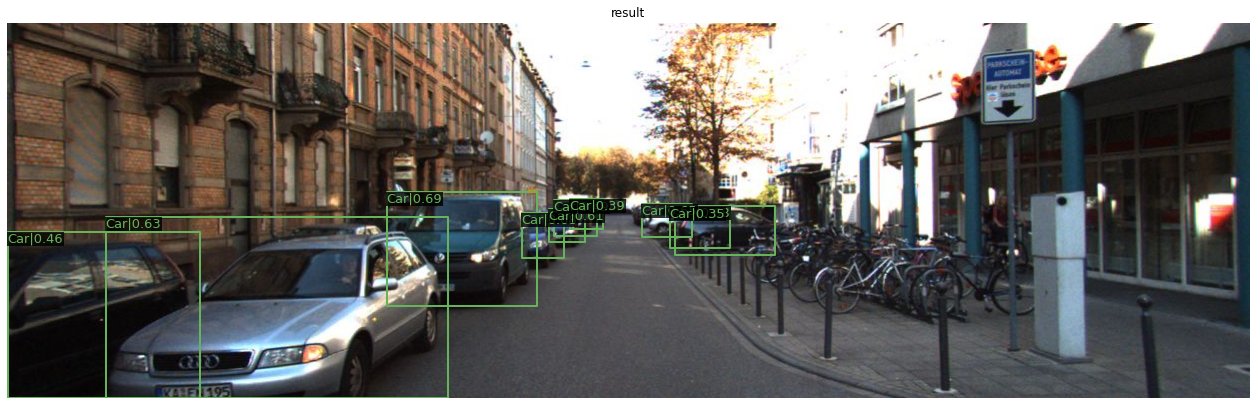

In [17]:
img = mmcv.imread('kitti_tiny/training/image_2/000068.jpeg')
model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)

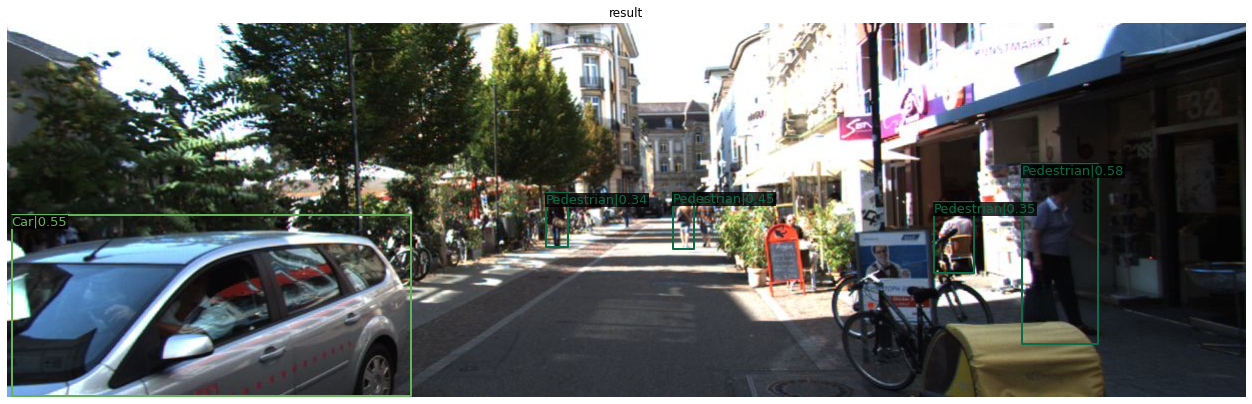

In [19]:
img = mmcv.imread('kitti_tiny/training/image_2/000015.jpeg')
model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)